# Azure AI Inference Tracing - Hello World Example
## 1. Env Setup
First, set up your environment variables and install packages:

In [ ]:
!pip install azure-ai-inference[opentelemetry]
!pip install opentelemetry 
!pip install opentelemetry-exporter-otlp
!pip install open-telemetry-sdk
!pip install azure-monitor-opentelemetry 
!pip install azure-search-documents

## 2. Setup Environment Variables and Tracing

In [30]:
import os
from opentelemetry import trace
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor, ConsoleSpanExporter
from azure.core.settings import settings
from opentelemetry.trace import get_tracer
from azure.monitor.opentelemetry import configure_azure_monitor
from azure.ai.inference.tracing import AIInferenceInstrumentor
import os
from opentelemetry import trace
from opentelemetry.trace import get_tracer
from azure.monitor.opentelemetry import configure_azure_monitor
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential

# Azure OpenAI Configuration
os.environ["AZURE_OPENAI_EMBEDDINGS_ENDPOINT"] = "<your-embeddings-endpoint>"
os.environ["AZURE_OPENAI_EMBEDDINGS_KEY"] = "<your-embeddings-key>"
os.environ["AZURE_OPENAI_CHAT_ENDPOINT"] = "<your-chat-endpoint>"
os.environ["AZURE_OPENAI_CHAT_KEY"] = "<your-chat-key>"
os.environ["AZURE_SEARCH_ENDPOINT"] = "<your-search-endpoint>"
os.environ["AZURE_SEARCH_INDEX"] = "<your-search-index>"
os.environ["AZURE_SEARCH_KEY"] = "<your-search-key>"
os.environ["APPLICATIONINSIGHTS_CONNECTION_STRING"] = "<your-app-insights-connection-string>"
os.environ["AZURE_TRACING_GEN_AI_CONTENT_RECORDING_ENABLED"] = "true"


# Configure Azure Monitor
configure_azure_monitor()

# Get tracer
tracer = get_tracer(__name__)

import os
from azure.ai.inference.tracing import AIInferenceInstrumentor
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Enable detailed tracing
os.environ['AZURE_TRACING_GEN_AI_CONTENT_RECORDING_ENABLED'] = 'true'

# Attempt to instrument AI Inference
try:
    AIInferenceInstrumentor().instrument()
    logger.info("AI Inference Instrumentation enabled successfully.")
except RuntimeError as e:
    if "Already instrumented" in str(e):
        logger.warning("AI Inference Instrumentation is already enabled.")
    else:
        logger.error(f"Failed to enable AI Inference Instrumentation: {str(e)}")
        raise


## 3. Simple Chat Function

In [31]:
@tracer.start_as_current_span("hello_world_chat_demo")
def hello_world_chat():
    try:
        # Create client
        client = ChatCompletionsClient(
            endpoint=os.environ["AZURE_OPENAI_CHAT_ENDPOINT"],
            credential=AzureKeyCredential(os.environ["AZURE_OPENAI_CHAT_KEY"])
        )
        
        # Add span attributes
        span = trace.get_current_span()
        span.set_attribute("operation", "chat_completion")
        
        # Simple chat
        messages = [
            SystemMessage(content="You are a helpful assistant."),
            UserMessage(content="Say hello!")
        ]
        
        # Get response
        response = client.complete(messages=messages)
        print(f"Assistant: {response.choices[0].message.content}")
        
    except Exception as e:
        span = trace.get_current_span()
        span.set_attribute("error", str(e))
        raise e
    
    finally:
        # Clean up
        AIInferenceInstrumentor().uninstrument()

# Run it
hello_world_chat()

Assistant: Hello! How can I assist you today?


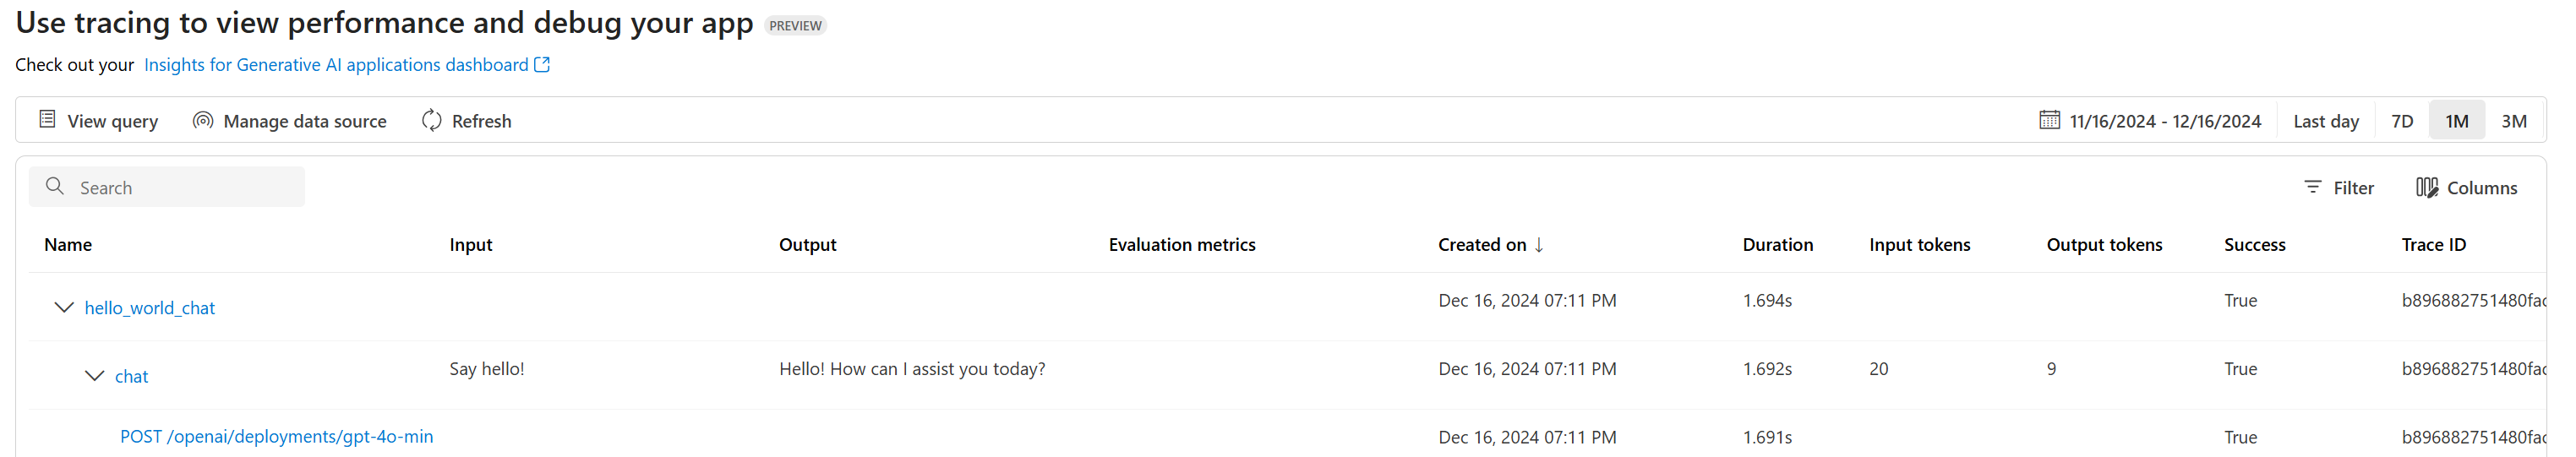
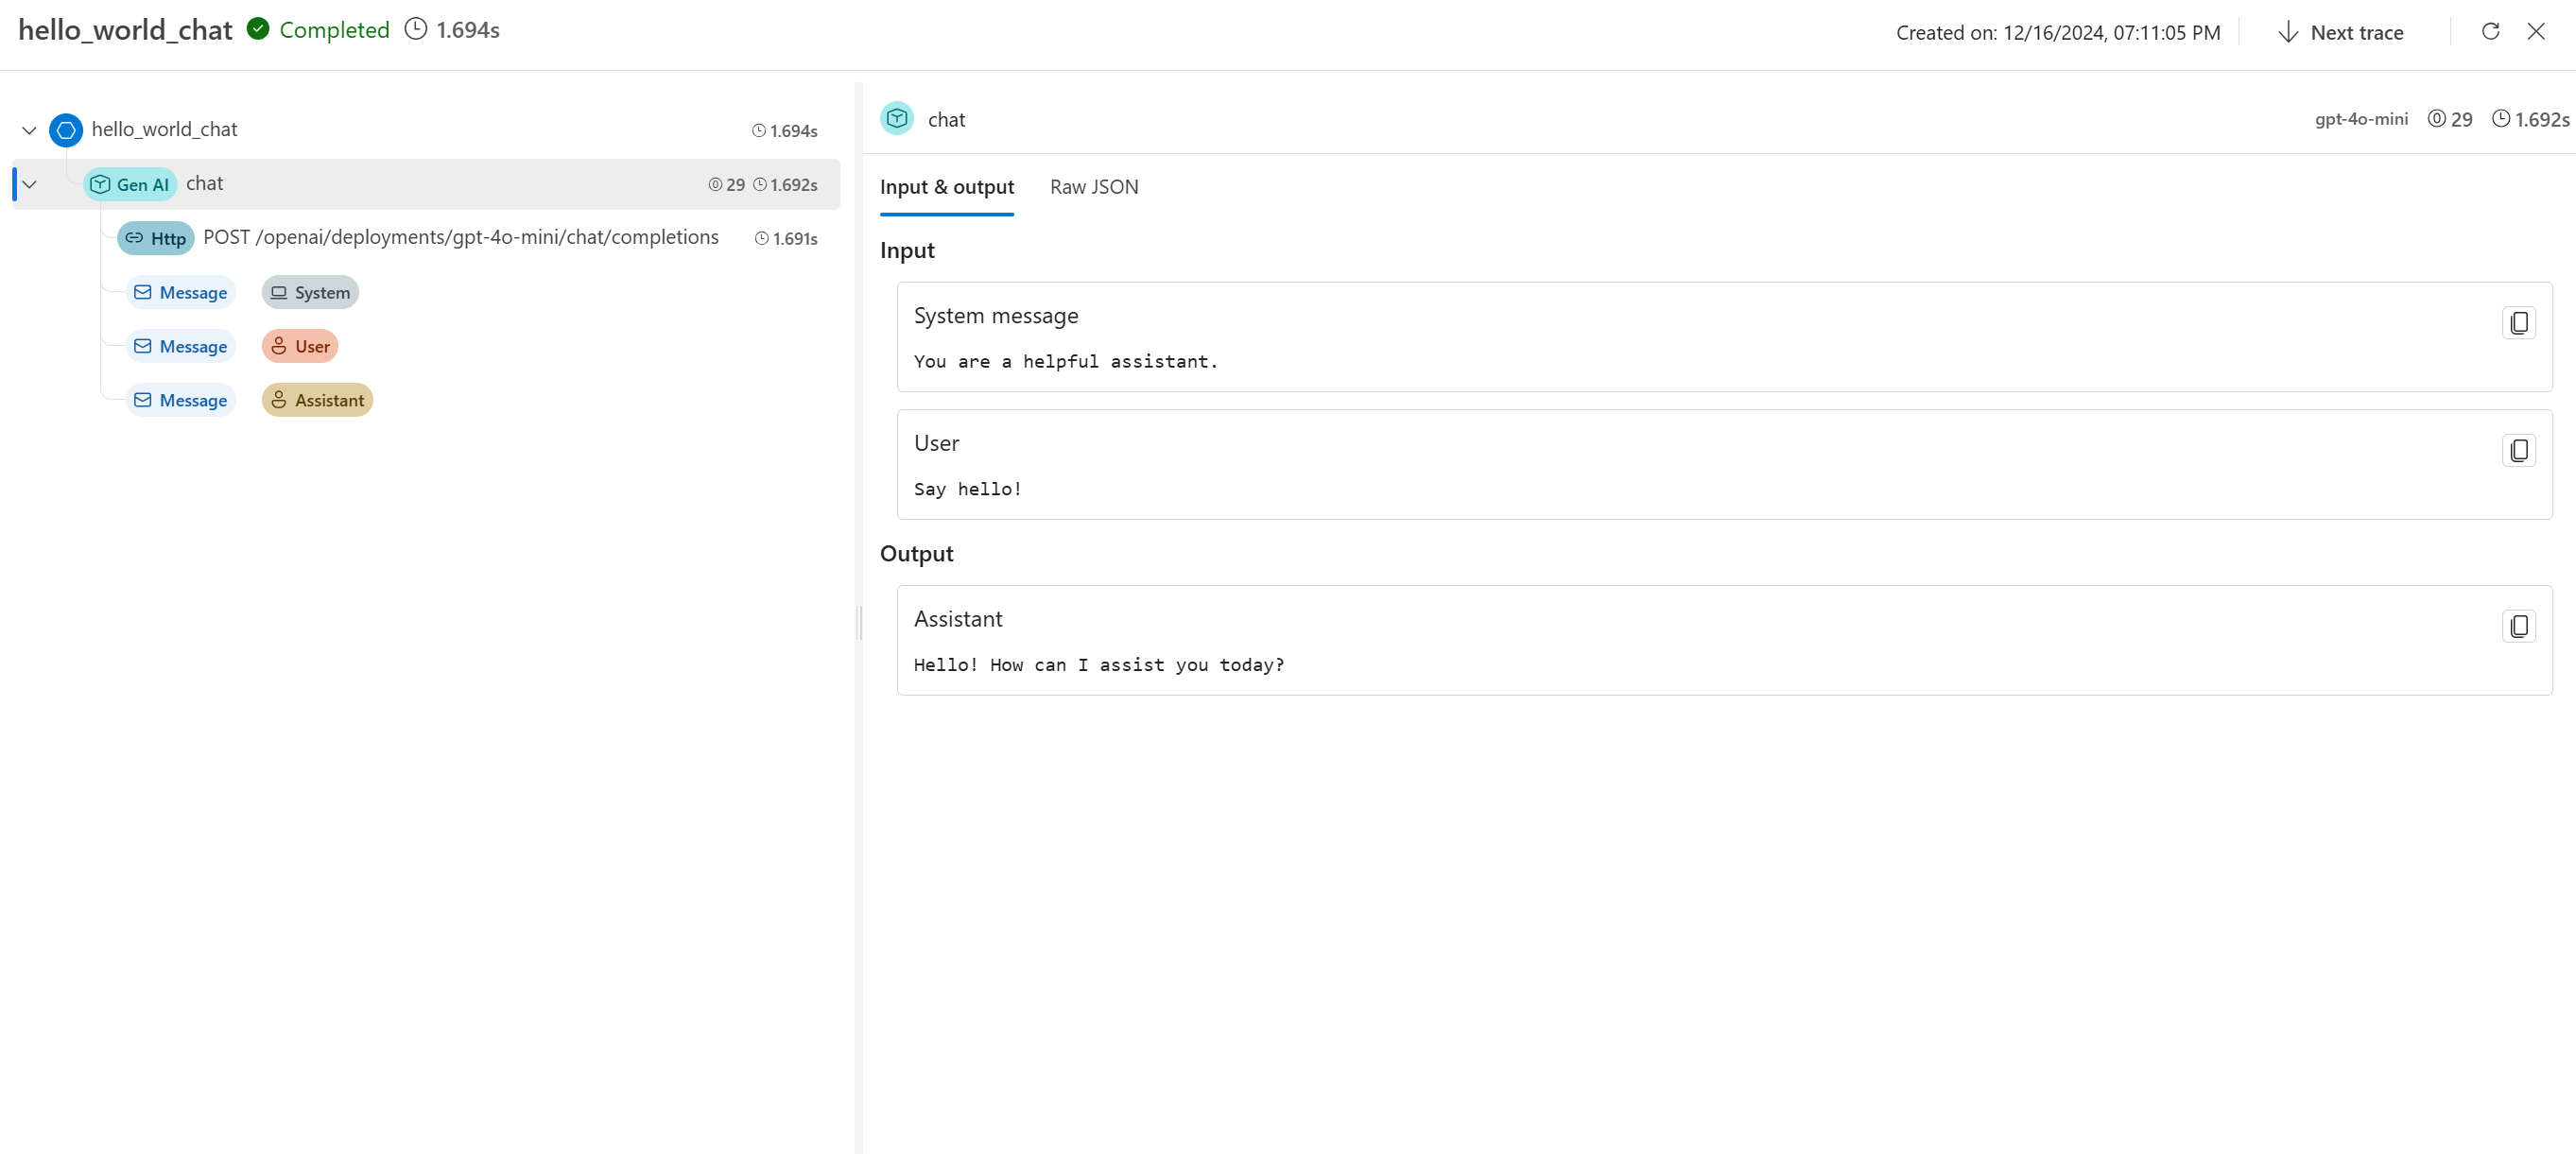

# Azure OpenAI RAG with Tracing in AI Foundry
In this section we'll go E2E RAG using Azure AI Search

In [32]:
import os
from opentelemetry import trace
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor, ConsoleSpanExporter
from azure.core.settings import settings
from azure.ai.inference import ChatCompletionsClient, EmbeddingsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.models import VectorizedQuery
from azure.search.documents.indexes.models import (
    SimpleField, SearchFieldDataType, SearchableField, SearchField,
    VectorSearch, HnswAlgorithmConfiguration, VectorSearchProfile, SearchIndex
)
from azure.ai.inference.tracing import AIInferenceInstrumentor

# Setup tracing
settings.tracing_implementation = "opentelemetry"
trace.set_tracer_provider(TracerProvider().add_span_processor(SimpleSpanProcessor(ConsoleSpanExporter())))
tracer = trace.get_tracer(__name__)

# Enable AI Inference tracing
AIInferenceInstrumentor().instrument()

## 1. Configuration

In [33]:
Azure OpenAI Configuration

os.environ["AZURE_OPENAI_EMBEDDINGS_ENDPOINT"] = "<your-embeddings-endpoint>"
os.environ["AZURE_OPENAI_EMBEDDINGS_KEY"] = "<your-embeddings-key>"
os.environ["AZURE_OPENAI_CHAT_ENDPOINT"] = "<your-chat-endpoint>"
os.environ["AZURE_OPENAI_CHAT_KEY"] = "<your-chat-key>"
os.environ["AZURE_SEARCH_ENDPOINT"] = "<your-search-endpoint>"
os.environ["AZURE_SEARCH_INDEX"] = "<your-search-index>"
os.environ["AZURE_SEARCH_KEY"] = "<your-search-key>"
os.environ["APPLICATIONINSIGHTS_CONNECTION_STRING"] = "<your-app-insights-connection-string>"
os.environ["AZURE_TRACING_GEN_AI_CONTENT_RECORDING_ENABLED"] = "true"

embeddings_client = EmbeddingsClient(
    endpoint=os.environ["AZURE_OPENAI_EMBEDDINGS_ENDPOINT"],
    credential=AzureKeyCredential(os.environ["AZURE_OPENAI_EMBEDDINGS_KEY"])
)

chat_client = ChatCompletionsClient(
    endpoint=os.environ["AZURE_OPENAI_CHAT_ENDPOINT"],
    credential=AzureKeyCredential(os.environ["AZURE_OPENAI_CHAT_KEY"])
)

search_client = SearchClient(
    endpoint=os.environ["AZURE_SEARCH_ENDPOINT"],
    index_name=os.environ["AZURE_SEARCH_INDEX"],
    credential=AzureKeyCredential(os.environ["AZURE_SEARCH_KEY"])
)

## 2. Create Search Index
This section sets up the Azure Search index with vector search capabilities. Run this once to create or update your index.

In [34]:
@tracer.start_as_current_span("setup_search_index")
def setup_search_index():
    """Create or update the Azure Search index"""
    try:
        index_client = SearchIndexClient(
            endpoint=os.environ["AZURE_SEARCH_ENDPOINT"],
            credential=AzureKeyCredential(os.environ["AZURE_SEARCH_KEY"])
        )

        fields = [
            SimpleField(name="hotelId", type=SearchFieldDataType.String, key=True),
            SearchableField(name="hotelName", type=SearchFieldDataType.String),
            SearchableField(name="description", type=SearchFieldDataType.String),
            SearchableField(name="category", type=SearchFieldDataType.String, filterable=True),
            SearchField(
                name="descriptionVector",
                type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                searchable=True,
                vector_search_dimensions=3072,  # Azure OpenAI text-embedding-3-large embedding dimensions
                vector_search_profile_name="myHnswProfile",
            ),
        ]

        vector_search = VectorSearch(
            algorithms=[HnswAlgorithmConfiguration(name="myHnsw")],
            profiles=[VectorSearchProfile(
                name="myHnswProfile",
                algorithm_configuration_name="myHnsw",
            )]
        )

        index = SearchIndex(
            name=os.environ["AZURE_SEARCH_INDEX"],
            fields=fields,
            vector_search=vector_search
        )
        
        result = index_client.create_or_update_index(index)
        print(f"Search index '{result.name}' created successfully")
        return result

    except Exception as e:
        span = trace.get_current_span()
        span.set_attribute("error", str(e))
        raise

# Create the index
_ = setup_search_index()

Search index 'ai-foundry-tracing-sample' created successfully


## 3. Upload Sample Data
This section creates embeddings for sample hotel data and uploads it to the search index.

In [35]:
@tracer.start_as_current_span("index_sample_data")
def index_sample_data():
    """Index sample hotel data with embeddings"""
    try:
        # Sample hotel data
        sample_hotels = [
            {
                "hotelId": "1",
                "hotelName": "Fancy Stay",
                "description": "Best hotel in town if you like luxury hotels.",
                "category": "Luxury",
            },
            {
                "hotelId": "2",
                "hotelName": "Roach Motel",
                "description": "Cheapest hotel in town. Infact, a motel.",
                "category": "Budget",
            },
            {
                "hotelId": "3",
                "hotelName": "EconoStay",
                "description": "Very popular hotel in town.",
                "category": "Budget",
            },
            {
                "hotelId": "4",
                "hotelName": "Modern Stay",
                "description": "Modern architecture, very polite staff and very clean. Also very affordable.",
                "category": "Luxury",
            },
            {
                "hotelId": "5",
                "hotelName": "Secret Point",
                "description": "One of the best hotel in town. The hotel is ideally located on the main commercial artery of the city in the heart of New York.",
                "category": "Boutique",
            },
        ]

        # Create embeddings for each hotel description
        span = trace.get_current_span()
        for hotel in sample_hotels:
            embedding_response = embeddings_client.embed(input=[hotel["description"]])
            hotel["descriptionVector"] = embedding_response.data[0].embedding
            span.set_attribute(f"embedded_hotel_{hotel['hotelId']}", "true")

        # Upload to search index
        search_client = SearchClient(
            endpoint=os.environ["AZURE_SEARCH_ENDPOINT"],
            index_name=os.environ["AZURE_SEARCH_INDEX"],
            credential=AzureKeyCredential(os.environ["AZURE_SEARCH_KEY"]),
        )

        result = search_client.upload_documents(documents=sample_hotels)
        span.set_attribute("documents_indexed", len(sample_hotels))
        print(f"Indexed {len(sample_hotels)} documents successfully")

    except Exception as e:
        span = trace.get_current_span()
        span.set_attribute("error", str(e))
        raise


# Index the sample data
index_sample_data()

Indexed 5 documents successfully


In [36]:
@tracer.start_as_current_span("search_documents")
def search_documents(query: str):
    """Vector search using embedded query"""
    span = trace.get_current_span()
    span.set_attribute("operation", "vector_search")
    
    # Create embedding for query
    embedding_response = embeddings_client.embed(input=[query])
    query_embedding = embedding_response.data[0].embedding
    
    # Set up search client
    search_client = SearchClient(
        endpoint=os.environ["AZURE_SEARCH_ENDPOINT"],
        index_name=os.environ["AZURE_SEARCH_INDEX"],
        credential=AzureKeyCredential(os.environ["AZURE_SEARCH_KEY"])
    )
    
    # Perform vector search
    vector_query = VectorizedQuery(
        vector=query_embedding,
        k_nearest_neighbors=3,
        fields="descriptionVector"
    )
    
    results = search_client.search(
        search_text=None,
        vector_queries=[vector_query],
        select=["hotelName", "description", "category"]
    )
    
    return list(results)

## 4. Define RAG Functions

In [37]:
@tracer.start_as_current_span("rag_process")
def process_rag_query(question: str):
    """Complete RAG process"""
    span = trace.get_current_span()
    span.set_attribute("question", question)
    
    # Search for relevant documents
    search_results = search_documents(question)
    
    # Format context
    context = "\n".join([
        f"Hotel: {result['hotelName']}\n"
        f"Category: {result['category']}\n"
        f"Description: {result['description']}\n"
        for result in search_results
    ])
    
    # Generate response
    messages = [
        SystemMessage(content=f"You are a helpful assistant. Use this context to answer questions:\n\n{context}"),
        UserMessage(content=question)
    ]
    
    response = chat_client.complete(messages=messages)
    return response.choices[0].message.content

In [38]:
try:
    # Test query
    question = "What's a good hotel close to city center?"
    answer = process_rag_query(question)
    
    print(f"Question: {question}")
    print(f"Answer: {answer}")
    
finally:
    # Clean up instrumentation
    AIInferenceInstrumentor().uninstrument()

Question: What's a good hotel close to city center?
Answer: Secret Point is a great option, as it is ideally located on the main commercial artery of the city in the heart of New York. This boutique hotel is one of the best in town and offers convenient access to the city center.


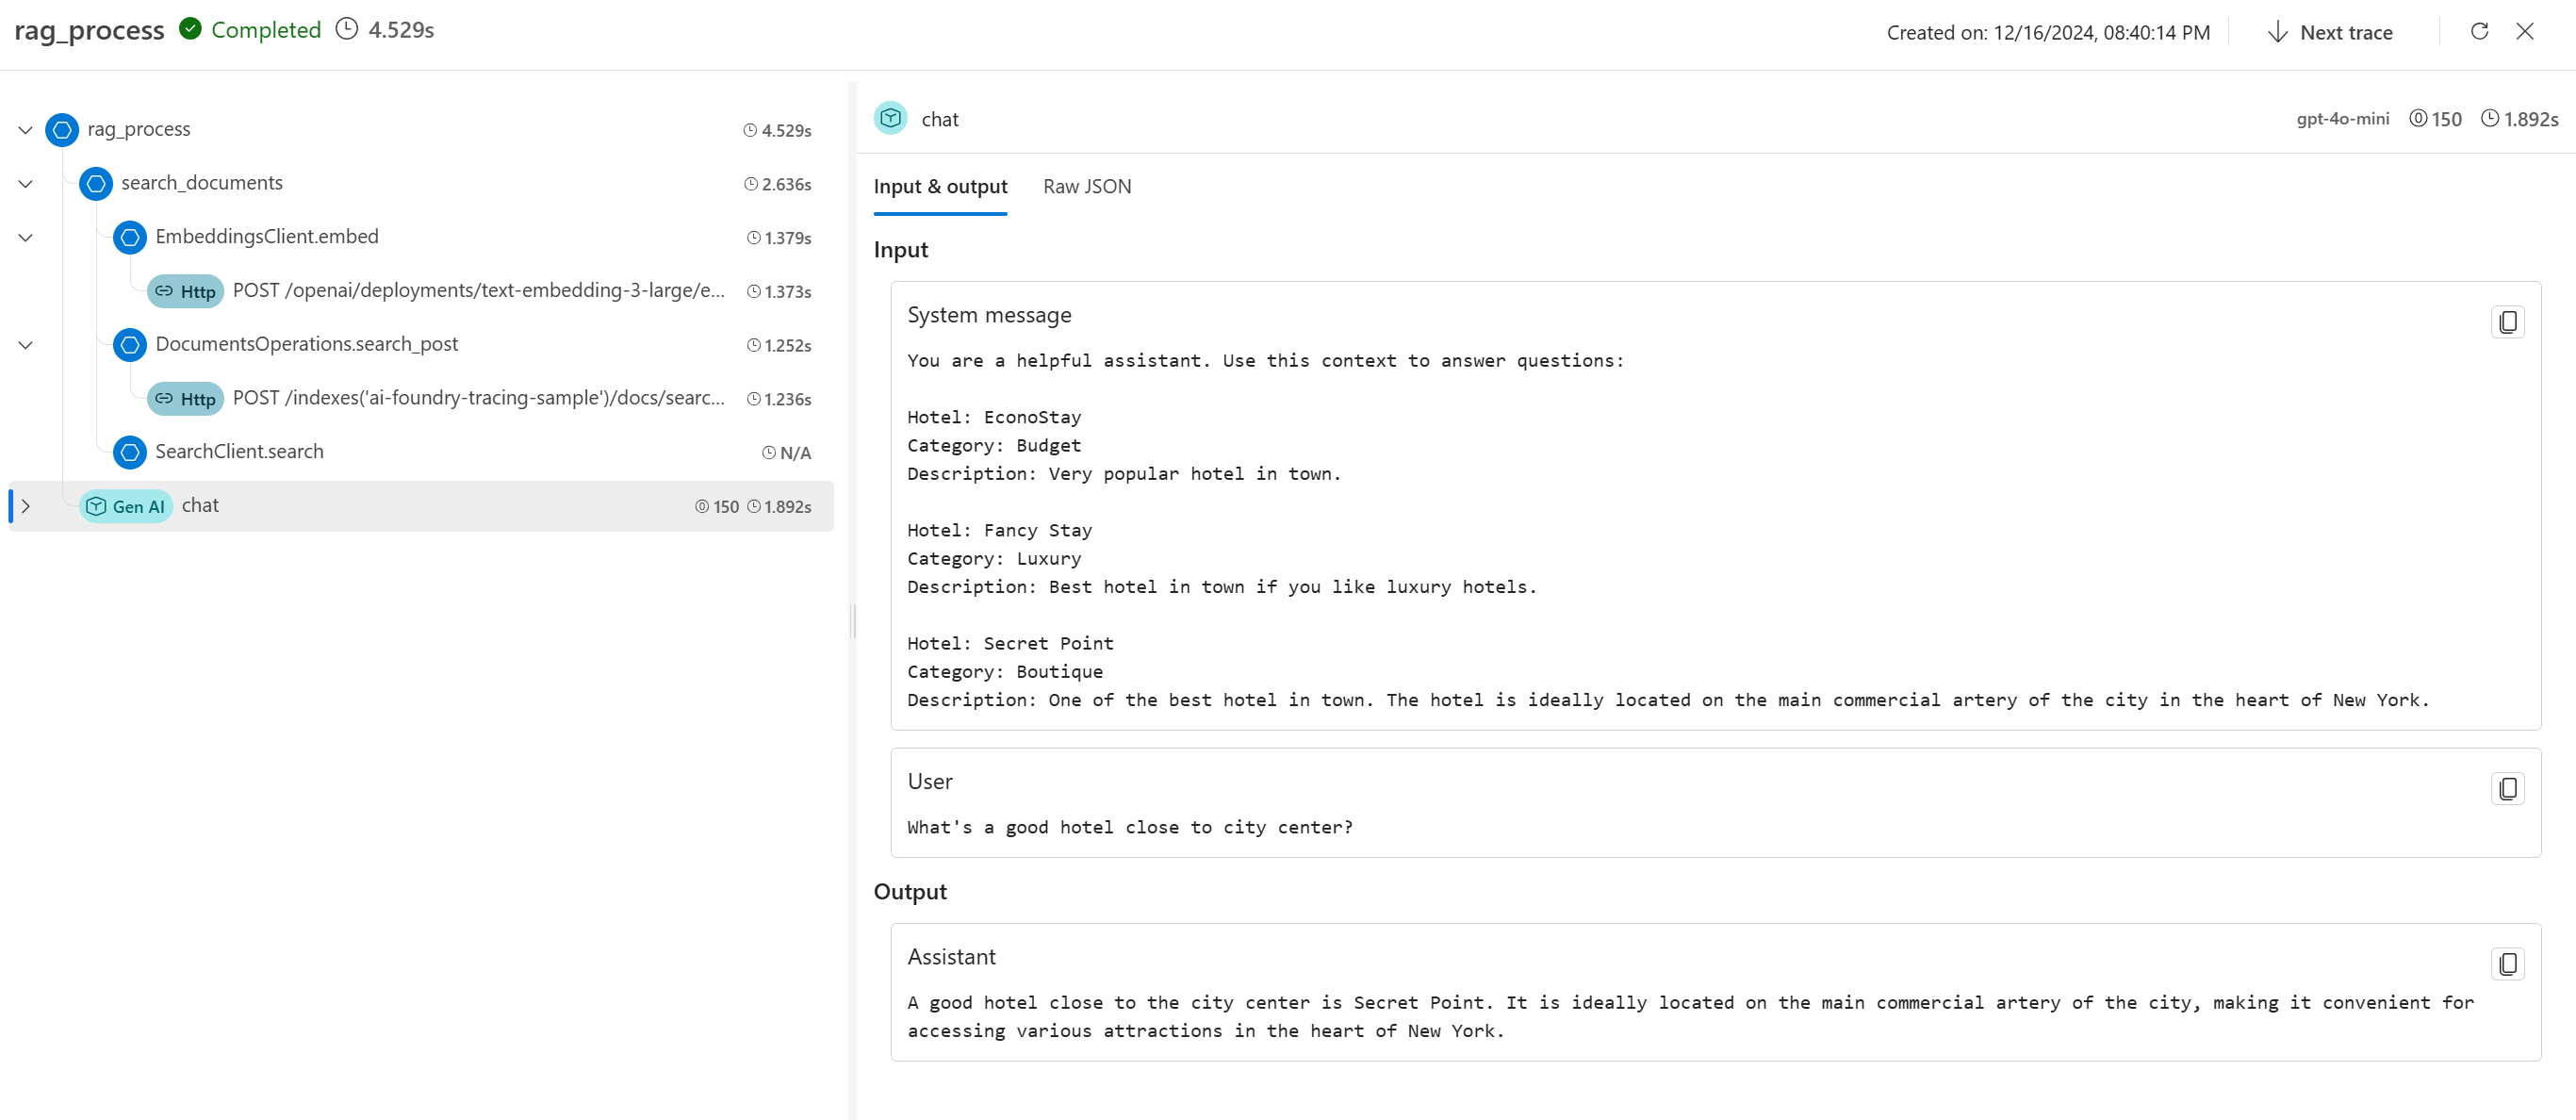